# Load the Data

In [1]:
import pandas as pd

# Load CSV files
users = pd.read_csv('./data/users.csv')
courses = pd.read_csv('./data/courses.csv')
learning_paths = pd.read_csv('./data/learning_path.csv')
enrollments = pd.read_csv('./data/enrollments.csv')
certificates = pd.read_csv('./data/certificates.csv')

# Display basic information
print(users.info())
print(courses.info())
print(learning_paths.info())
print(enrollments.info())
print(certificates.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        500 non-null    int64 
 1   name      500 non-null    object
 2   email     500 non-null    object
 3   password  500 non-null    object
 4   role      500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3678 non-null   int64  
 1   title             3678 non-null   object 
 2   description       3678 non-null   object 
 3   duration          3678 non-null   float64
 4   difficulty        3678 non-null   object 
 5   learning_path_id  3678 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 172.5+ KB
None
<class 'pandas.core.fra

# Handle Missing Values

In [2]:
# Check for missing values
print(users.isnull().sum())
print(courses.isnull().sum())
print(learning_paths.isnull().sum())
print(enrollments.isnull().sum())
print(certificates.isnull().sum())

# Example: Fill missing completionDate with NaT
enrollments['completionDate'] = pd.to_datetime(enrollments['completionDate'], errors='coerce')


id          0
name        0
email       0
password    0
role        0
dtype: int64
id                  0
title               0
description         0
duration            0
difficulty          0
learning_path_id    0
dtype: int64
learning_path_id    0
title               0
description         0
dtype: int64
id                         0
userId                     0
courseId                   0
enrollmentDate             0
completionPercentage       0
completionDate          4970
dtype: int64
id                0
userId            0
courseId          0
certificateUrl    0
issuedAt          0
dtype: int64


In [3]:
# Convert dates to datetime
enrollments['enrollmentDate'] = pd.to_datetime(enrollments['enrollmentDate'])
certificates['issuedAt'] = pd.to_datetime(certificates['issuedAt'])

# Convert other necessary columns
courses['duration'] = courses['duration'].astype(int)


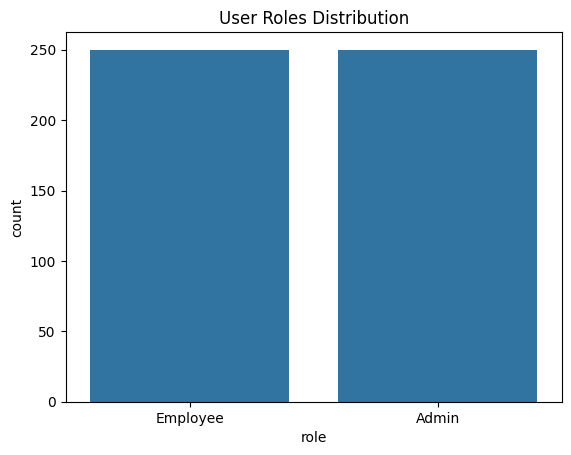

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of roles
sns.countplot(data=users, x='role')
plt.title('User Roles Distribution')
plt.show()


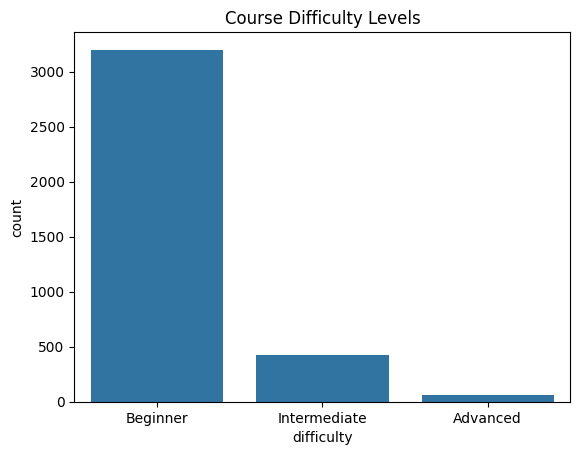

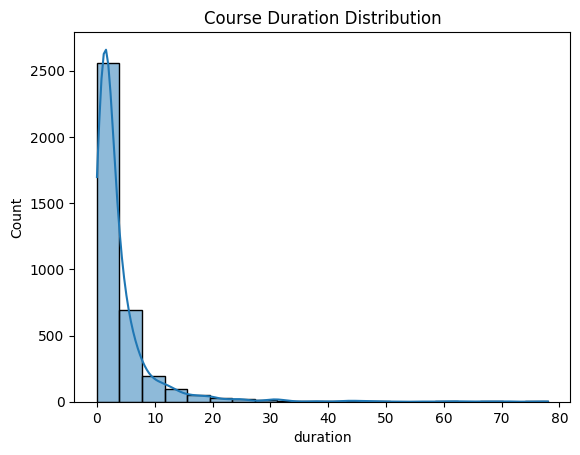

In [5]:
# Distribution of course difficulties
sns.countplot(data=courses, x='difficulty')
plt.title('Course Difficulty Levels')
plt.show()

# Distribution of course durations
sns.histplot(courses['duration'], bins=20, kde=True)
plt.title('Course Duration Distribution')
plt.show()


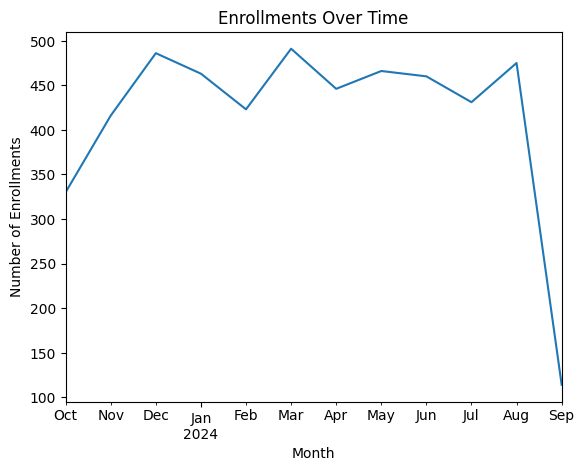

In [6]:
# Enrollment over time
enrollments['year_month'] = enrollments['enrollmentDate'].dt.to_period('M')
enrollments.groupby('year_month').size().plot(kind='line')
plt.title('Enrollments Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Enrollments')
plt.show()


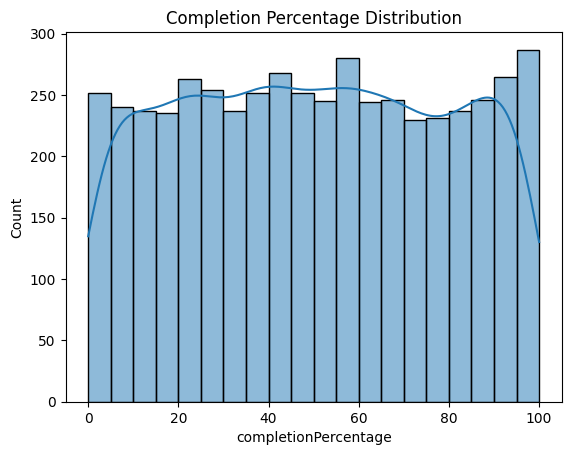

In [7]:
# Completion percentage distribution
sns.histplot(enrollments['completionPercentage'], bins=20, kde=True)
plt.title('Completion Percentage Distribution')
plt.show()


In [8]:
# Number of completed courses per user
completed_courses = enrollments[enrollments['completionPercentage'] == 100].groupby('userId').size().reset_index(name='completed_courses')
print(completed_courses.columns)
print(users.columns)

# Average completion percentage per user
avg_completion = enrollments.groupby('userId')['completionPercentage'].mean().reset_index(name='avg_completion')
print(avg_completion.columns)

# Merge with users
users = users.merge(completed_courses, left_on='id', right_on="userId", how='left', suffixes=("", "_xom")).merge(avg_completion, on='userId', how='left', suffixes=("", "_avg"))
users['completed_courses'] = users['completed_courses'].fillna(0)
users['avg_completion'] = users['avg_completion'].fillna(0)
users.head()



Index(['userId', 'completed_courses'], dtype='object')
Index(['id', 'name', 'email', 'password', 'role'], dtype='object')
Index(['userId', 'avg_completion'], dtype='object')


,id,name,email,password,role,userId,completed_courses,avg_completion
0,1,Michele Tanner,isaiahjordan@example.org,$2a$10$YvZWEO2jzLiAZdTu0hAPxefD5src/cXhbBF9Gia...,Employee,NaN,0.0,0.0
1,2,Kathryn Collins,matthewmills@example.com,$2a$10$YvZWEO2jzLiAZdTu0hAPxefD5src/cXhbBF9Gia...,Admin,NaN,0.0,0.0
2,3,Harold Smith,bnelson@example.org,$2a$10$YvZWEO2jzLiAZdTu0hAPxefD5src/cXhbBF9Gia...,Admin,NaN,0.0,0.0
3,4,Sarah Stanley,jphillips@example.net,$2a$10$YvZWEO2jzLiAZdTu0hAPxefD5src/cXhbBF9Gia...,Employee,NaN,0.0,0.0
4,5,Miguel Harper,whitney74@example.com,$2a$10$YvZWEO2jzLiAZdTu0hAPxefD5src/cXhbBF9Gia...,Employee,NaN,0.0,0.0


In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode difficulty
le = LabelEncoder()
courses['difficulty_encoded'] = le.fit_transform(courses['difficulty'])


In [10]:
# Time since last enrollment
enrollments['enrollmentDate'] = pd.to_datetime(enrollments['enrollmentDate'])
latest_enrollment = enrollments.groupby('userId')['enrollmentDate'].max().reset_index(name='latest_enrollment')
users = users.merge(latest_enrollment, on='userId', how='left')
users['time_since_last_enrollment'] = (pd.Timestamp('2024-10-10') - users['latest_enrollment']).dt.days
users['time_since_last_enrollment'] = users['time_since_last_enrollment'].fillna((pd.Timestamp('2024-10-10') - enrollments['enrollmentDate'].min()).days)


In [18]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Prepare the data
reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(enrollments[['userId', 'courseId', 'completionPercentage']], reader)

# Split into training and testing
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\VarshaPriyadarshini\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\VarshaPriyadarshini\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\VarshaPriyadarshini\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernel

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [ ]:
pip uninstall numpy


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Prepare the data
reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(enrollments[['userId', 'courseId', 'completionPercentage']], reader)

# Split into training and testing
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
# Initialize the algorithm
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)


In [ ]:
# Predict on the testset
predictions = algo.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')


In [ ]:
from collections import defaultdict

def get_top_n_recommendations(algo, user_id, courses, n=5):
    # Get all course IDs
    all_course_ids = courses['id'].unique()
    
    # Get courses the user has already interacted with
    user_courses = enrollments[enrollments['userId'] == user_id]['courseId'].unique()
    
    # Courses not yet taken
    courses_to_predict = [course for course in all_course_ids if course not in user_courses]
    
    # Predict completion percentage for these courses
    predictions = [algo.predict(user_id, course_id) for course_id in courses_to_predict]
    
    # Get top N courses with highest predicted completion percentage
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Retrieve course details
    top_n_courses = [courses[courses['id'] == pred.iid].iloc[0] for pred in top_n]
    
    return top_n_courses

# Example: Recommend for user with userId=1
recommended_courses = get_top_n_recommendations(algo, user_id=1, courses=courses, n=5)
for course in recommended_courses:
    print(f"Course ID: {course['id']}, Title: {course['title']}, Predicted Completion: {course['completionPercentage']}")
